## **Fast AI Experements Based on [this](https://towardsdatascience.com/transfer-learning-using-the-fastai-library-d686b238213e) blog**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!unzip drive/My\ Drive/ammi-2020-convnets.zip 


Archive:  drive/My Drive/ammi-2020-convnets.zip
replace extraimages/extraimages/extra-image-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install pretrainedmodels
!pip uninstall torch torchvision -y 
!pip install torch==1.4.0 torchvision==0.5.0 

Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl


# Importing Fast AI library

In [0]:
import os 
import pretrainedmodels

In [0]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

from math import floor

# Looking at the data

In [0]:
train_path = "./train/train"
test_path = "./test/test/0"

In [0]:
def get_labels(file_path): 
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_levels = len(split_dir_name)
    label  = split_dir_name[dir_levels - 1]
    return(label)

In [19]:
get_labels("./train/train/cgm/train-cgm-528.jpg")

'cgm'

In [20]:
from glob import glob
imagePatches = glob("./train/train/*/*.*", recursive=True)
imagePatches[0:10]

['./train/train/healthy/train-healthy-103.jpg',
 './train/train/healthy/train-healthy-280.jpg',
 './train/train/healthy/train-healthy-191.jpg',
 './train/train/healthy/train-healthy-161.jpg',
 './train/train/healthy/train-healthy-243.jpg',
 './train/train/healthy/train-healthy-313.jpg',
 './train/train/healthy/train-healthy-218.jpg',
 './train/train/healthy/train-healthy-203.jpg',
 './train/train/healthy/train-healthy-17.jpg',
 './train/train/healthy/train-healthy-166.jpg']

In [0]:
path=""

transform_kwargs = {"do_flip": True,
                    "flip_vert": True,
                    "max_rotate": 180,
                    "max_zoom": 1.1,
                    "max_lighting": 0.2,
                    "max_warp": 0.2,
                    "p_affine": 0.75,
                    "p_lighting": 0.7}

tfms = get_transforms(**transform_kwargs)


In [0]:
data = ImageDataBunch.from_name_func(path, imagePatches, label_func=get_labels,  size=256, 
                                     bs=32,num_workers=2,test = test_path,ds_tfms=tfms
                                  ).normalize(imagenet_stats)

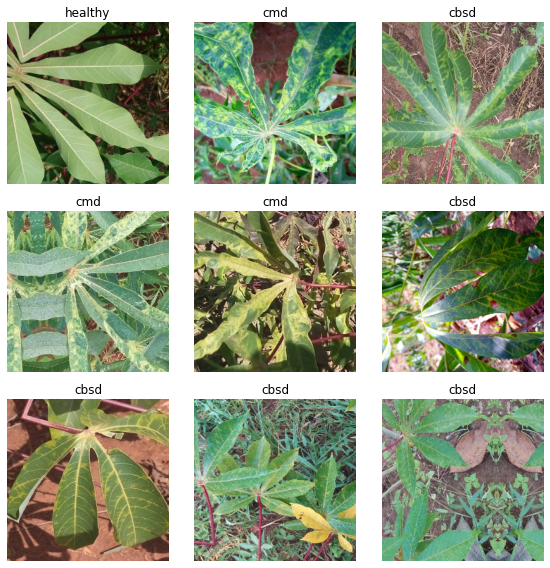

In [63]:
data.show_batch(rows=3, figsize=(8,8))

In [64]:
print(data.classes)
len(data.classes),data.c

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


(5, 5)

# Model Explore

# Transfer learning using a pre-trained model: ResNet 50

In [67]:
## To create a ResNET 50 with pretrained weights
learn = create_cnn(data,models.densenet121, metrics=[error_rate,accuracy])
learn.load('densenet121_86.pt')
# learn = create_cnn(data,models.vgg19_bn, metrics=[error_rate,accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learner(data=ImageDataBunch;

Train: LabelList (4525 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: .;

Valid: LabelList (1131 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
cmd,cbsd,cmd,cmd,cbsd
Path: .;

Test: LabelList (3774 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _Dense

In [53]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.588312,0.940225,0.322723,0.677277,01:08
1,1.206990,0.866914,0.273210,0.726790,01:00
2,1.079893,0.770681,0.248453,0.751547,01:01
3,0.891524,0.724378,0.235190,0.764810,01:01
4,0.847062,0.710769,0.229885,0.770115,01:01
5,0.777992,0.680745,0.229001,0.770999,01:01
6,0.712192,0.631437,0.205128,0.794872,01:01
7,0.644231,0.605074,0.205128,0.794872,01:01
8,0.625361,0.600485,0.211317,0.788683,01:01
9,0.610975,0.588488,0.198939,0.801061,01:01


KeyboardInterrupt: ignored

In [0]:
learn.save('vgg_86.pt')

# Result Exploration

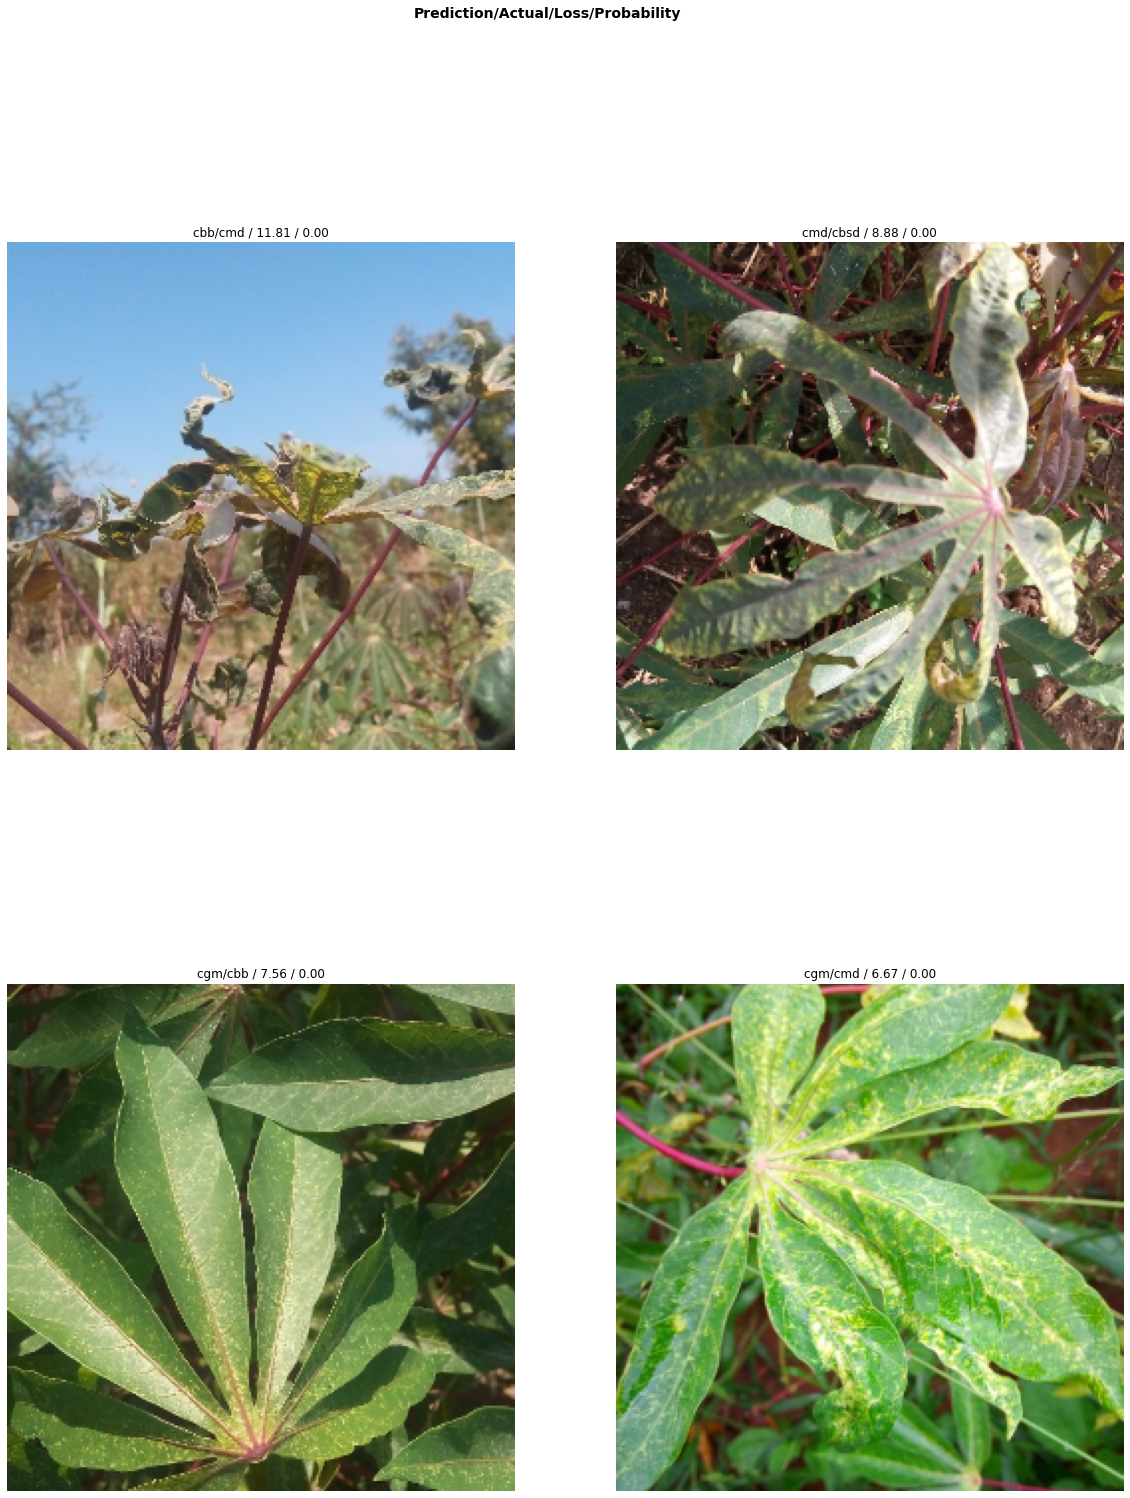

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(20,25))

# Confusion Matrix

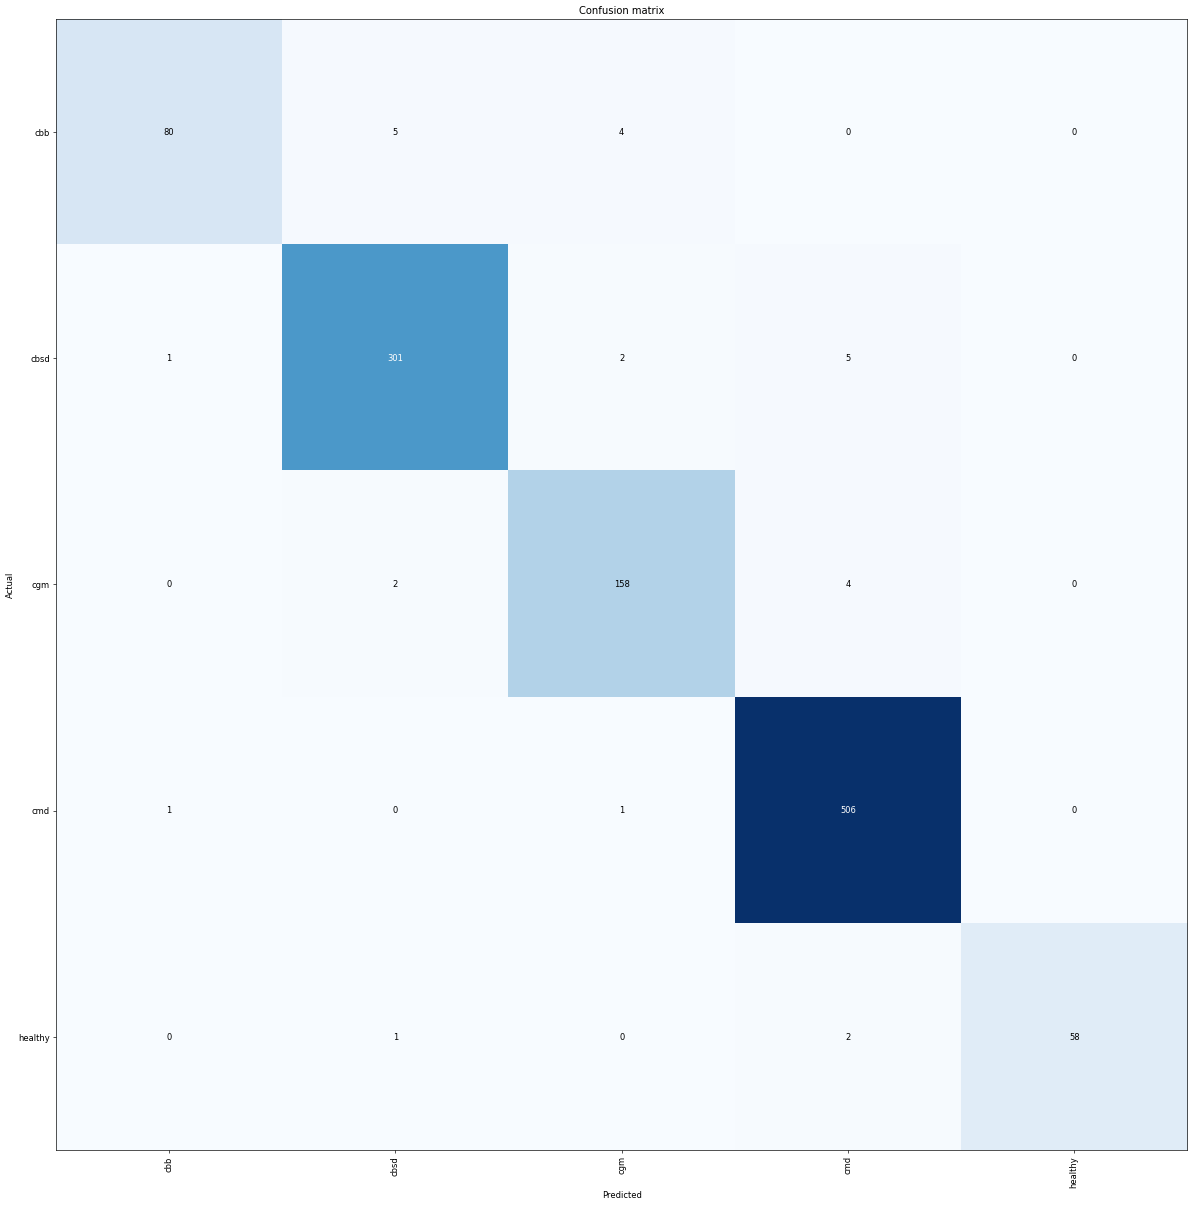

In [74]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

# LR Finder

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


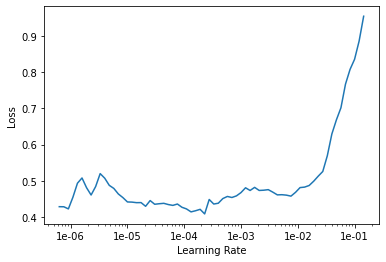

In [68]:
learn.lr_find()
learn.recorder.plot()

In [75]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.652920,0.912612,0.248453,0.751547,01:02
1,0.620391,0.478725,0.143236,0.856764,01:02
2,0.531150,0.413674,0.128205,0.871795,01:02
3,0.444224,0.365663,0.109637,0.890363,01:02
4,0.361994,0.343160,0.104332,0.895668,01:02


In [0]:
learn.save('densenet121_89.pt')